In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PATH = "logs/experiments.json"

with open(PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.json_normalize(data)

# total latency
timing_cols = ['timings_ms.inference', 'timings_ms.upload_client']
df["total_ms"] = df[timing_cols].sum(axis=1, skipna=True)

print("Rows:", len(df))
print("FPS:", sorted(df["sampling_fps"].dropna().unique()))
print("Modes:", df["mode"].value_counts(dropna=False).to_dict())
print("Timing cols:", timing_cols)
display(df.head())

timing_cols


Rows: 240
FPS: [np.int64(1), np.int64(2), np.int64(5), np.int64(10)]
Modes: {'frames': 180, 'video': 60}
Timing cols: ['timings_ms.inference', 'timings_ms.upload_client']


,clip_id,mode,device_id,sampling_fps,prediction,num_frames,ground_truth,is_correct,predictions_by_threshold.0.1,predictions_by_threshold.0.2,...,predictions_by_threshold.0.5,predictions_by_threshold.0.6,predictions_by_threshold.0.7,predictions_by_threshold.0.8,predictions_by_threshold.0.9,timings_ms.capture,timings_ms.inference,timings_ms.upload_client,timings_ms.sampling,total_ms
0,c88c363b-e144-421d-b3e3-997e462eeb66,video,raspberry_pi_cam_v3,10,Violence,43,NoViolence,False,Violence,Violence,...,Violence,Violence,NoViolence,NoViolence,NoViolence,6724.0,4068,4247,NaN,8315
1,c88c363b-e144-421d-b3e3-997e462eeb66,frames,raspberry_pi_cam_v3,1,Violence,4,NoViolence,False,Violence,Violence,...,Violence,Violence,NoViolence,NoViolence,NoViolence,NaN,298,1249,1215.0,1547
2,c88c363b-e144-421d-b3e3-997e462eeb66,frames,raspberry_pi_cam_v3,2,Violence,9,NoViolence,False,Violence,Violence,...,Violence,Violence,NoViolence,NoViolence,NoViolence,NaN,684,741,1848.0,1425
3,c88c363b-e144-421d-b3e3-997e462eeb66,frames,raspberry_pi_cam_v3,5,Violence,22,NoViolence,False,Violence,Violence,...,Violence,NoViolence,NoViolence,NoViolence,NoViolence,NaN,1639,1844,2430.0,3483
4,564e0862-82da-426d-afc9-c57002f0f317,video,raspberry_pi_cam_v3,10,Violence,43,NoViolence,False,Violence,Violence,...,Violence,Violence,NoViolence,NoViolence,NoViolence,6730.0,3885,4357,NaN,8242


['timings_ms.inference', 'timings_ms.upload_client']

In [3]:
print("Ground truth distribution:", df["ground_truth"].value_counts(dropna=False).to_dict())
print("Prediction distribution:", df["prediction"].value_counts(dropna=False).to_dict())

# missing per colonne chiave
cols_check = ["sampling_fps", "mode", "ground_truth", "prediction", "total_ms"]
missing = df[cols_check].isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_ratio"))


Ground truth distribution: {'NoViolence': 120, 'Violence': 120}
Prediction distribution: {'Violence': 140, 'NoViolence': 100}


,missing_ratio
sampling_fps,0.0
mode,0.0
ground_truth,0.0
prediction,0.0
total_ms,0.0


In [4]:
POS_LABEL = "Violence"

def classification_metrics(group: pd.DataFrame) -> pd.Series:
    y_true = (group["ground_truth"] == POS_LABEL).astype(int)
    y_pred = (group["prediction"]  == POS_LABEL).astype(int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())

    n = len(group)
    acc  = (tp + tn) / n if n else np.nan
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    rec  = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    return pd.Series({
        "n": n, "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "accuracy": acc, "precision": prec, "recall": rec
    })

metrics_fps = (
    df.groupby("sampling_fps")
      .apply(classification_metrics)
      .reset_index()
      .sort_values("sampling_fps")
)

display(metrics_fps)


C:\Users\meazz\AppData\Local\Temp\ipykernel_14676\1872768194.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(classification_metrics)


,sampling_fps,n,tp,tn,fp,fn,accuracy,precision,recall
0,1,60.0,23.0,24.0,6.0,7.0,0.783333,0.793103,0.766667
1,2,60.0,27.0,23.0,7.0,3.0,0.833333,0.794118,0.900000
2,5,60.0,30.0,22.0,8.0,0.0,0.866667,0.789474,1.000000
3,10,60.0,29.0,20.0,10.0,1.0,0.816667,0.743590,0.966667


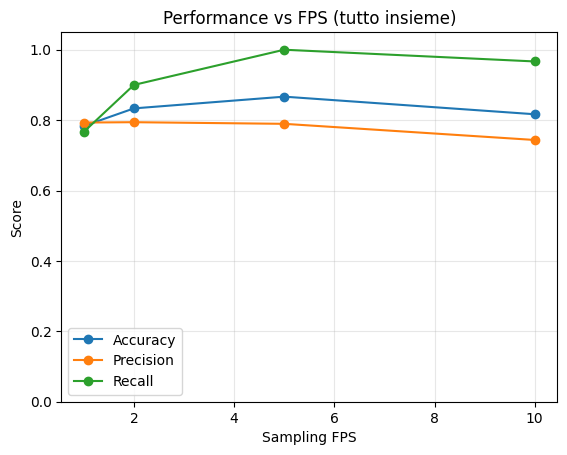

In [5]:
x = metrics_fps["sampling_fps"].to_numpy()

plt.figure()
plt.plot(x, metrics_fps["accuracy"], marker="o", label="Accuracy")
plt.plot(x, metrics_fps["precision"], marker="o", label="Precision")
plt.plot(x, metrics_fps["recall"], marker="o", label="Recall")
plt.xlabel("Sampling FPS")
plt.ylabel("Score")
plt.title("Performance vs FPS (tutto insieme)")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


C:\Users\meazz\AppData\Local\Temp\ipykernel_14676\2136390725.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cm = df.groupby("sampling_fps").apply(confusion_counts).reset_index().sort_values("sampling_fps")


,sampling_fps,TP,FP,FN,TN
0,1,23,6,7,24
1,2,27,7,3,23
2,5,30,8,0,22
3,10,29,10,1,20


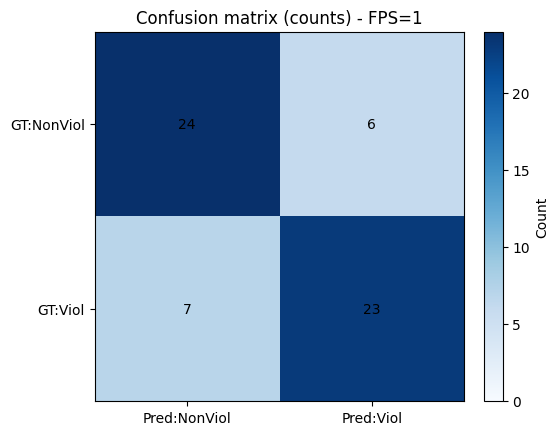

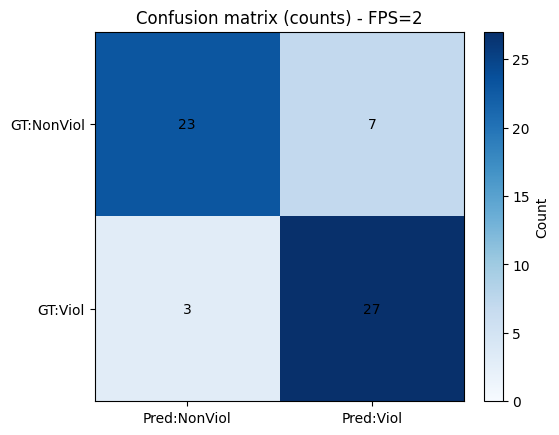

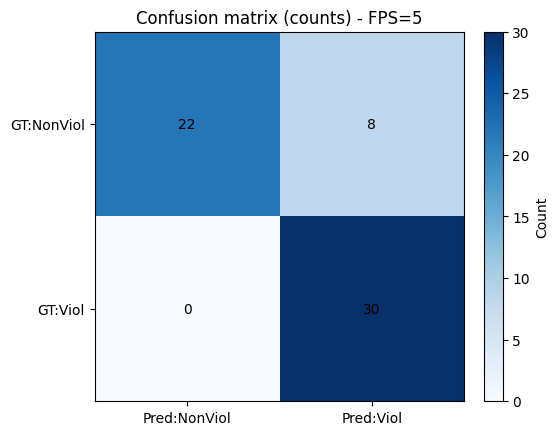

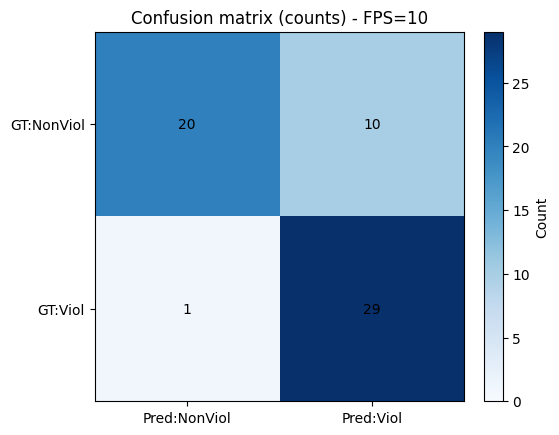

In [21]:
def confusion_counts(group: pd.DataFrame) -> pd.Series:
    y_true = (group["ground_truth"] == POS_LABEL).astype(int)
    y_pred = (group["prediction"]  == POS_LABEL).astype(int)
    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    return pd.Series({"TP": tp, "FP": fp, "FN": fn, "TN": tn})

cm = df.groupby("sampling_fps").apply(confusion_counts).reset_index().sort_values("sampling_fps")
display(cm)

# heatmap "manuale": una figura per ogni fps (leggibile)
# heatmap con valori NON normalizzati (conteggi assoluti)
for _, r in cm.iterrows():
    fps = r["sampling_fps"]

    mat = np.array([[r["TN"], r["FP"]],
                    [r["FN"], r["TP"]]], dtype=float)

    plt.figure()
    im = plt.imshow(mat, cmap="Blues", vmin=0, vmax=mat.max())

    plt.xticks([0, 1], ["Pred:NonViol", "Pred:Viol"])
    plt.yticks([0, 1], ["GT:NonViol", "GT:Viol"])
    plt.title(f"Confusion matrix (counts) - FPS={fps}")

    for i in range(2):
        for j in range(2):
            plt.text(
                j, i,
                f"{int(mat[i, j])}",
                ha="center", va="center",
                color="black"
            )

    plt.colorbar(im, fraction=0.046, pad=0.04, label="Count")
    plt.show()



In [7]:
def p95(x):
    x = pd.to_numeric(x, errors="coerce").dropna()
    return float(np.percentile(x, 95)) if len(x) else np.nan

lat_fps = (
    df.groupby("sampling_fps")
      .agg(
          n=("total_ms", "count"),
          total_mean=("total_ms", "mean"),
          total_median=("total_ms", "median"),
          total_p95=("total_ms", p95),
      )
      .reset_index()
      .sort_values("sampling_fps")
)

display(lat_fps)


,sampling_fps,n,total_mean,total_median,total_p95
0,1,60,982.716667,945.0,1544.15
1,2,60,1599.433333,1504.0,2069.25
2,5,60,3408.716667,3400.0,3777.85
3,10,60,8371.583333,8207.0,9015.75


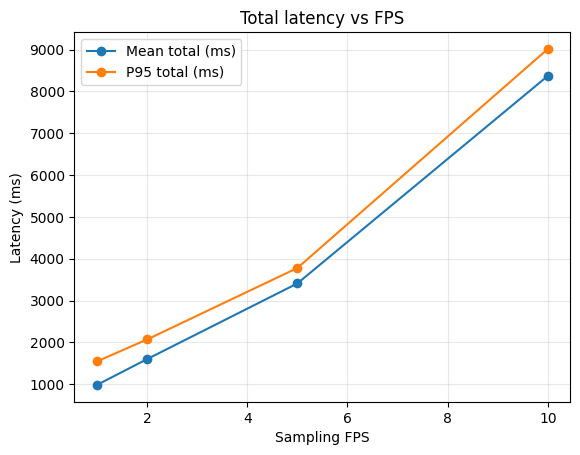

In [8]:
plt.figure()
plt.plot(lat_fps["sampling_fps"], lat_fps["total_mean"], marker="o", label="Mean total (ms)")
plt.plot(lat_fps["sampling_fps"], lat_fps["total_p95"], marker="o", label="P95 total (ms)")
plt.xlabel("Sampling FPS")
plt.ylabel("Latency (ms)")
plt.title("Total latency vs FPS")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


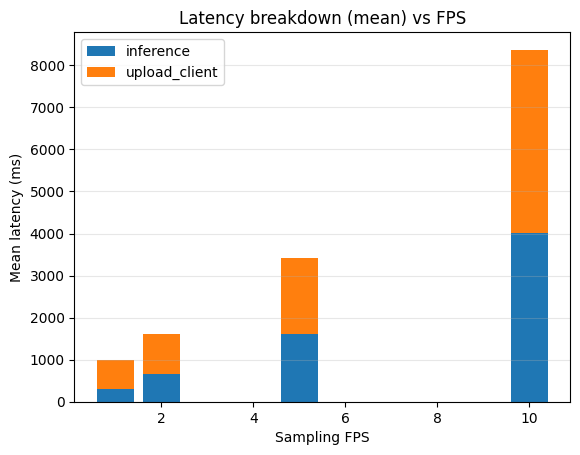

In [22]:
components = ['timings_ms.inference', 'timings_ms.upload_client']
components = sorted(components) 

comp_means = (
    df.groupby("sampling_fps")[components]
      .mean(numeric_only=True)
      .reset_index()
      .sort_values("sampling_fps")
)

x = comp_means["sampling_fps"].to_numpy()
bottom = np.zeros(len(comp_means))

plt.figure()
for c in components:
    vals = comp_means[c].fillna(0).to_numpy()
    plt.bar(x, vals, bottom=bottom, label=c.replace("timings_ms.", ""))
    bottom += vals

plt.xlabel("Sampling FPS")
plt.ylabel("Mean latency (ms)")
plt.title("Latency breakdown (mean) vs FPS")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.show()


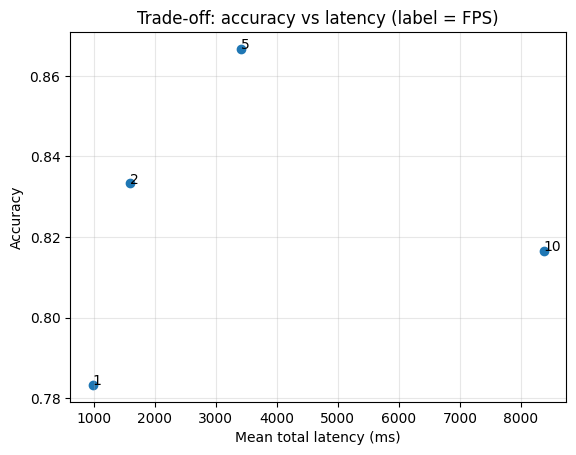

,sampling_fps,accuracy,precision,recall,total_mean
0,1,0.783333,0.793103,0.766667,982.716667
1,2,0.833333,0.794118,0.900000,1599.433333
2,5,0.866667,0.789474,1.000000,3408.716667
3,10,0.816667,0.743590,0.966667,8371.583333


In [11]:
trade = pd.merge(
    metrics_fps[["sampling_fps","accuracy","precision","recall"]],
    lat_fps[["sampling_fps","total_mean"]],
    on="sampling_fps",
    how="inner"
).sort_values("sampling_fps")

plt.figure()
plt.scatter(trade["total_mean"], trade["accuracy"])
for _, r in trade.iterrows():
    plt.annotate(str(int(r["sampling_fps"])), (r["total_mean"], r["accuracy"]))

plt.xlabel("Mean total latency (ms)")
plt.ylabel("Accuracy")
plt.title("Trade-off: accuracy vs latency (label = FPS)")
plt.grid(True, alpha=0.3)
plt.show()

display(trade)


,sampling_fps,threshold,n,accuracy,precision,recall,tp,tn,fp,fn
0,1,0.1,60,0.783333,0.697674,1.000000,30,17,13,0
4,1,0.2,60,0.783333,0.697674,1.000000,30,17,13,0
8,1,0.3,60,0.800000,0.714286,1.000000,30,18,12,0
12,1,0.4,60,0.766667,0.722222,0.866667,26,20,10,4
16,1,0.5,60,0.783333,0.793103,0.766667,23,24,6,7
20,1,0.6,60,0.783333,0.814815,0.733333,22,25,5,8
24,1,0.7,60,0.650000,0.909091,0.333333,10,29,1,20
28,1,0.8,60,0.566667,1.000000,0.133333,4,30,0,26
32,1,0.9,60,0.500000,NaN,0.000000,0,30,0,30
1,2,0.1,60,0.733333,0.666667,0.933333,28,16,14,2


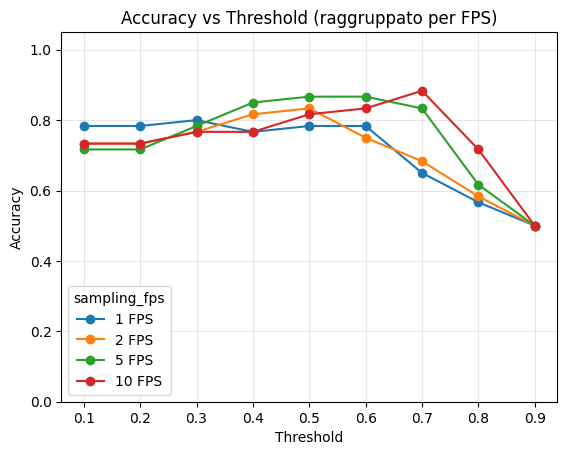

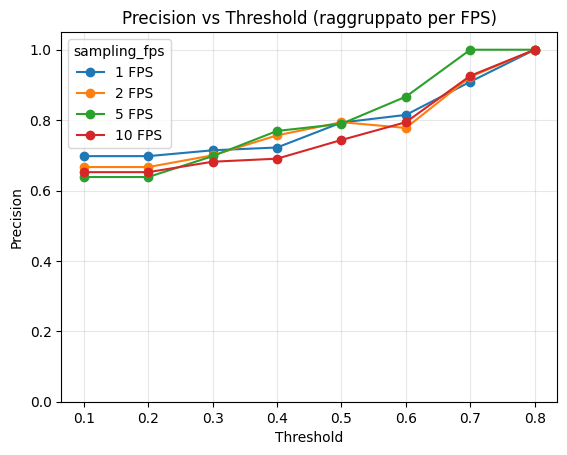

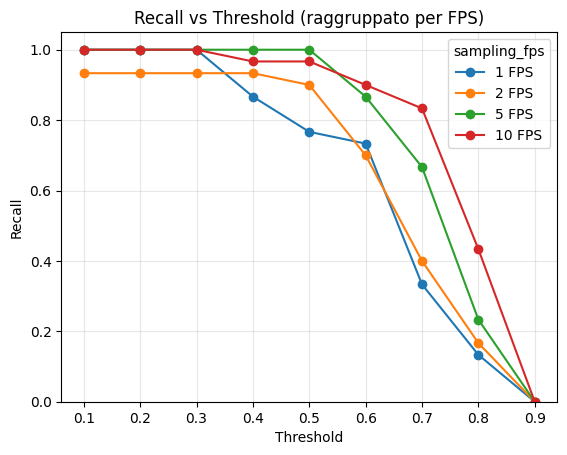

In [14]:
# Analisi performance (accuracy/precision/recall) al variare della threshold, raggruppata per FPS
# Richiede colonne del tipo: predictions_by_threshold.<soglia> (es. predictions_by_threshold.0.5)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

POS_LABEL = "Violence"

# trova colonne predictions_by_threshold.*
thr_cols = [c for c in df.columns if c.startswith("predictions_by_threshold.")]
if len(thr_cols) == 0:
    raise ValueError("Nessuna colonna 'predictions_by_threshold.*' trovata nel DataFrame df.")

# estrai soglie come float dai nomi colonna
def extract_thr(colname: str) -> float:
    m = re.match(r"^predictions_by_threshold\.(.+)$", colname)
    if not m:
        return np.nan
    return float(m.group(1))

thresholds = sorted([extract_thr(c) for c in thr_cols])

def compute_metrics(y_true_bin: np.ndarray, y_pred_bin: np.ndarray):
    tp = int(((y_true_bin == 1) & (y_pred_bin == 1)).sum())
    tn = int(((y_true_bin == 0) & (y_pred_bin == 0)).sum())
    fp = int(((y_true_bin == 0) & (y_pred_bin == 1)).sum())
    fn = int(((y_true_bin == 1) & (y_pred_bin == 0)).sum())
    n = int(len(y_true_bin))
    acc  = (tp + tn) / n if n else np.nan
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    rec  = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    return acc, prec, rec, tp, tn, fp, fn, n

rows = []
for thr in thresholds:
    col = f"predictions_by_threshold.{thr}"
    # drop righe con prediction_thr mancante
    tmp = df[["sampling_fps", "ground_truth", col]].dropna(subset=["sampling_fps", "ground_truth", col]).copy()
    tmp["y_true"] = (tmp["ground_truth"] == POS_LABEL).astype(int)
    tmp["y_pred"] = (tmp[col] == POS_LABEL).astype(int)

    for fps, g in tmp.groupby("sampling_fps"):
        acc, prec, rec, tp, tn, fp, fn, n = compute_metrics(g["y_true"].to_numpy(), g["y_pred"].to_numpy())
        rows.append({
            "sampling_fps": fps,
            "threshold": thr,
            "n": n,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "tp": tp, "tn": tn, "fp": fp, "fn": fn
        })

metrics_thr_fps = pd.DataFrame(rows).sort_values(["sampling_fps", "threshold"])
display(metrics_thr_fps)

# Grafici: una figura per metrica (curve threshold->metrica, una curva per FPS)
for metric in ["accuracy", "precision", "recall"]:
    plt.figure()
    for fps in sorted(metrics_thr_fps["sampling_fps"].unique()):
        sub = metrics_thr_fps[metrics_thr_fps["sampling_fps"].eq(fps)].sort_values("threshold")
        plt.plot(sub["threshold"], sub[metric], marker="o", label=f"{fps} FPS")
    plt.xlabel("Threshold")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} vs Threshold (raggruppato per FPS)")
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend(title="sampling_fps")
    plt.show()
